<a href="https://colab.research.google.com/github/neesarg123/Devanagari-Letters-DL/blob/main/Devanagari_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf

from tensorflow import keras
from keras import layers, metrics
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from torchvision import transforms

### Loading the dataset into runtime

In [ ]:
if not os.path.isdir('/content/Dataset'):
   !unzip "/content/drive/MyDrive/Devanagari Letters/DevanagariHandwrittenCharacterDataset.zip" -d "/content/Dataset/"

### Dataset:
1. Number of Images: *92,000 >>> 72,000 images in consonant datasest and 20,000 images in numeral dataset*
2. Number of Training Images: *78,200*
3. Number of Testing Images: *13,800*
4. Number of Classes: *46*
5. Number of Images Per Class *(Training: 1,700)*
6. Number of Images Per Class *(Testing: 300)*

In [3]:
# how many total classes are there
nclasses = len(os.listdir('/content/Dataset/DevanagariHandwrittenCharacterDataset/Train'))

# names of the classes
classes = [sub_dir for sub_dir in os.listdir('/content/Dataset/DevanagariHandwrittenCharacterDataset/Train')]

print("Number of classes:", nclasses)
print("Classes:", classes)

# Number of images (in train of all classes)

for sub_dir, c in zip(os.listdir('/content/Dataset/DevanagariHandwrittenCharacterDataset/Train'), classes):
  print(c + ":", len(os.listdir(f'/content/Dataset/DevanagariHandwrittenCharacterDataset/Train/{sub_dir}')))

print("#######################################################################")

# same thing for test
for sub_dir, c in zip(os.listdir('/content/Dataset/DevanagariHandwrittenCharacterDataset/Test'), classes):
  print(c + ":", len(os.listdir(f'/content/Dataset/DevanagariHandwrittenCharacterDataset/Test/{sub_dir}')))

Number of classes: 46
Classes: ['character_12_thaa', 'character_36_gya', 'character_18_da', 'character_19_dha', 'character_9_jha', 'digit_5', 'character_4_gha', 'character_33_ha', 'digit_0', 'digit_8', 'digit_7', 'character_20_na', 'digit_6', 'character_34_chhya', 'character_13_daa', 'character_1_ka', 'character_35_tra', 'character_11_taamatar', 'character_28_la', 'character_27_ra', 'digit_1', 'character_31_petchiryakha', 'character_16_tabala', 'character_10_yna', 'character_2_kha', 'character_29_waw', 'digit_2', 'digit_3', 'character_32_patalosaw', 'character_21_pa', 'character_26_yaw', 'character_3_ga', 'character_17_tha', 'character_24_bha', 'character_14_dhaa', 'character_8_ja', 'character_15_adna', 'digit_9', 'character_30_motosaw', 'character_23_ba', 'character_22_pha', 'digit_4', 'character_25_ma', 'character_5_kna', 'character_6_cha', 'character_7_chha']
character_12_thaa: 1700
character_36_gya: 1700
character_18_da: 1700
character_19_dha: 1700
character_9_jha: 1700
digit_5: 17

### Images


*   Every image is of size (32, 32) pixels
*   Every image is black and white (0 - 255) 



Image Size: (32, 32) pixels


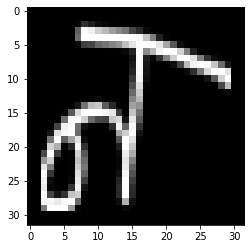

In [4]:
# plotting one out to see it
img = Image.open('/content/Dataset/DevanagariHandwrittenCharacterDataset/Train/character_20_na/11050.png')

plt.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=255)

print("Image Size:", img.size, "pixels")

### Training and Validation

#### Parameters

In [13]:
batch_size = 64
img_height = 32
img_width = 32 

#### Splitting Data

In [14]:
train_ds = keras.utils.image_dataset_from_directory(
                                                    directory='/content/Dataset/DevanagariHandwrittenCharacterDataset/Train',
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    seed=100,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    image_size=(img_height, img_width)
                                                   )

Found 78200 files belonging to 46 classes.
Using 62560 files for training.


In [15]:
val_ds = keras.utils.image_dataset_from_directory(
                                                    directory='/content/Dataset/DevanagariHandwrittenCharacterDataset/Train',
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    seed=100,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    image_size=(img_height, img_width)
                                                   )

Found 78200 files belonging to 46 classes.
Using 15640 files for validation.


#### Visualizing Training Images Data

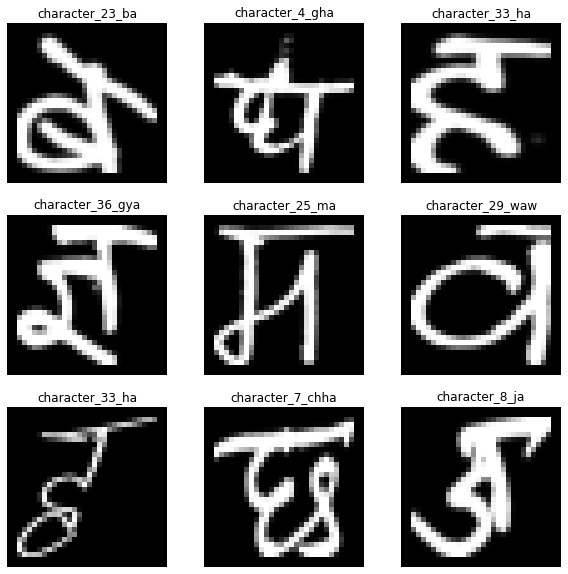

In [16]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().squeeze().astype("uint8"), cmap='gray', vmin=0, vmax=255)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

#### Configuration for Faster Performance in Training

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Initializing a Model

In [22]:
def init_model():
  model = Sequential()
  model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)))  # normalizing pixel values
  model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', name='conv2D_1'))  # first convolution layer
  model.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1'))  # first max pooling layer
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='conv2D_2'))  # second convolution layer
  model.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2'))  # second max pooling layer 
  model.add(Dropout(seed=100, rate=0.2))  # ignoring 20% inputs 
  model.add(Flatten())  # flattening for following feed forward NN layers
  model.add(Dense(units=128, activation='relu', name='dense_1'))  # first dense layer 
  model.add(Dense(units=64, activation='relu', name='dense_2'))  # second dense layer
  model.add(Dense(units=len(class_names), activation='softmax', name='output'))  # output layer that will predict image class
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

  return model

#### Training

In [23]:
model = init_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 conv2D_1 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 6, 6, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 2304)             

In [24]:
early_stopping_monitor = EarlyStopping(patience=2)  # stop early if there is no improvement in 2 epochs 
epochs = 10 
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
978/978 - 85s - loss: 0.7413 - accuracy: 0.7894 - precision: 0.9089 - recall: 0.7288 - val_loss: 0.2335 - val_accuracy: 0.9320 - val_precision: 0.9520 - val_recall: 0.9168 - 85s/epoch - 87ms/step
Epoch 2/10
978/978 - 64s - loss: 0.1929 - accuracy: 0.9418 - precision: 0.9552 - recall: 0.9300 - val_loss: 0.1560 - val_accuracy: 0.9535 - val_precision: 0.9654 - val_recall: 0.9432 - 64s/epoch - 66ms/step
Epoch 3/10
978/978 - 69s - loss: 0.1229 - accuracy: 0.9622 - precision: 0.9693 - recall: 0.9564 - val_loss: 0.1158 - val_accuracy: 0.9638 - val_precision: 0.9706 - val_recall: 0.9591 - 69s/epoch - 70ms/step
Epoch 4/10
978/978 - 67s - loss: 0.0910 - accuracy: 0.9711 - precision: 0.9757 - recall: 0.9677 - val_loss: 0.1027 - val_accuracy: 0.9700 - val_precision: 0.9743 - val_recall: 0.9668 - 67s/epoch - 68ms/step
Epoch 5/10
978/978 - 65s - loss: 0.0705 - accuracy: 0.9765 - precision: 0.9793 - recall: 0.9741 - val_loss: 0.1028 - val_accuracy: 0.9694 - val_precision: 0.9732 - val_reca

#### Training Loss & Validation Loss

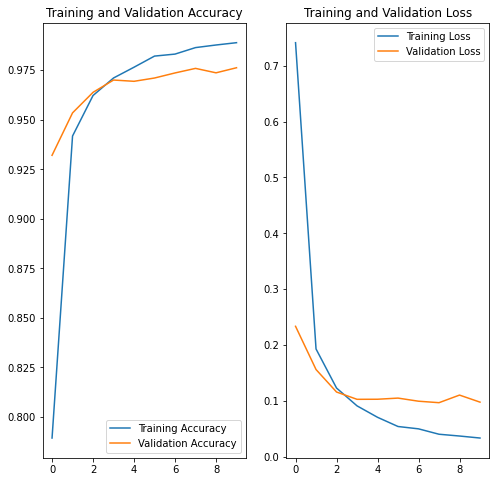

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Testing on New Data

#### Testing Data

In [26]:
test_ds = keras.utils.image_dataset_from_directory(
                                                    directory='/content/Dataset/DevanagariHandwrittenCharacterDataset/Test',
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    seed=100,
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    image_size=(img_height, img_width)
                                                   )

Found 13800 files belonging to 46 classes.


#### Evaluating the Model on Testing Data

In [28]:
def f1_score(prec, rec):
  return 2 * prec * rec / (prec + rec)
  
score = model.evaluate(test_ds, batch_size=batch_size, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print('Test F1 Score:', str(f1_score(score[2], score[3])))

216/216 - 9s - loss: 0.0896 - accuracy: 0.9761 - precision: 0.9778 - recall: 0.9751 - 9s/epoch - 44ms/step
Test loss: 0.08961883187294006
Test accuracy: 0.9760869741439819
Test F1 Score: 0.9764167881659377


### Prediction Visualization

Enter path of test image: /content/Dataset/DevanagariHandwrittenCharacterDataset/Test/digit_4/103811.png
0.056965128


(-0.5, 31.5, 31.5, -0.5)

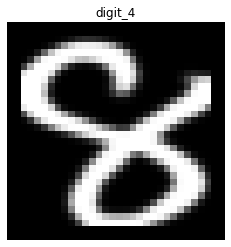

In [29]:
test_img_path = input("Enter path of test image: ")

img = Image.open(test_img_path)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(np.max(score))
plt.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=255)
plt.title(class_names[np.argmax(score)])
plt.axis("off")

### Saving Model

In [30]:
model.save("/content/drive/MyDrive/Model/")